In this notebook, we replicate the analysis of notebook 14 for synthetic graphs generated using the `dgvae` method instead of `graphrnn`.

We find the following:

???

In [1]:
import pickle
import numpy as np
import networkx as nx
import os
import pickle

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

Load the training datasets (numbered 11 to 20).

In [3]:
training_graphs = {}
for i in range(11, 21):
    with open(f'deezer_ego_nets/split/deezer_edge_lists_100_nodes_set_{i}.pkl', 'rb') as ff:
        training_graphs[i-10] = [nx.from_edgelist(l) for l in pickle.load(ff)]
#     print(len(training_graphs[i-10]))

Load a (disjoint?) test dataset.

In [4]:
with open('deezer_subset_test.pkl', 'rb') as ff:
    test = pickle.load(ff)

In [5]:
testing_graphs = [nx.from_edgelist(l) for l in test]

Load synthetic datasets.

In [6]:
synthetic_graphs = {}

In [55]:
for i in range(1, 11):
    filename = f'vae/dgvae/deezer-ego-nets_our_vae_deezer_edge_lists_100_nodes_set_{i}_generated_graph.pkl'
    print(f'Loading {filename}...')
    with open(filename, 'rb') as ff:
        synthetic_graphs[i] = [nx.from_edgelist(l) for l in pickle.load(ff)]
        # Remove self-edges which do not make sense here.
        for g in synthetic_graphs[i]:
            g.remove_edges_from(nx.selfloop_edges(G))
    print(f'Loaded {len(synthetic_graphs[i])} graphs.')

Loading vae/dgvae/deezer-ego-nets_our_vae_deezer_edge_lists_100_nodes_set_1_generated_graph.pkl...
Loaded 99 graphs.
Loading vae/dgvae/deezer-ego-nets_our_vae_deezer_edge_lists_100_nodes_set_2_generated_graph.pkl...
Loaded 99 graphs.
Loading vae/dgvae/deezer-ego-nets_our_vae_deezer_edge_lists_100_nodes_set_3_generated_graph.pkl...
Loaded 99 graphs.
Loading vae/dgvae/deezer-ego-nets_our_vae_deezer_edge_lists_100_nodes_set_4_generated_graph.pkl...
Loaded 99 graphs.
Loading vae/dgvae/deezer-ego-nets_our_vae_deezer_edge_lists_100_nodes_set_5_generated_graph.pkl...
Loaded 99 graphs.
Loading vae/dgvae/deezer-ego-nets_our_vae_deezer_edge_lists_100_nodes_set_6_generated_graph.pkl...
Loaded 99 graphs.
Loading vae/dgvae/deezer-ego-nets_our_vae_deezer_edge_lists_100_nodes_set_7_generated_graph.pkl...
Loaded 99 graphs.
Loading vae/dgvae/deezer-ego-nets_our_vae_deezer_edge_lists_100_nodes_set_8_generated_graph.pkl...
Loaded 99 graphs.
Loading vae/dgvae/deezer-ego-nets_our_vae_deezer_edge_lists_100_

Some plots to get an idea of representativity.

In [72]:
def summarize(training_graphs, synthetic_graphs):
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.hist([len(g.nodes) for g in training_graphs], 20, facecolor='b', alpha=.5, density=True)
    plt.hist([len(g.nodes) for g in synthetic_graphs], 20, facecolor='g', alpha=.5, density=True)
    plt.title('Graph Size')
    plt.subplot(1, 2, 2)
    plt.hist([nx.density(g) for g in training_graphs], 20, facecolor='b', alpha=.5, density=False)
    # Using only 2 bins so that it is displayed.
    plt.hist([nx.density(g) for g in synthetic_graphs], 2, facecolor='g', alpha=.5, density=False)
    plt.xlim([0,1.01])
    plt.title('Density')

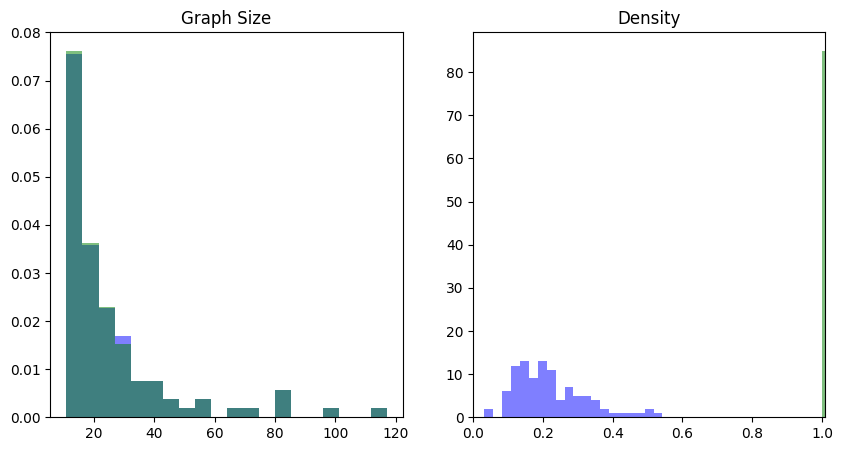

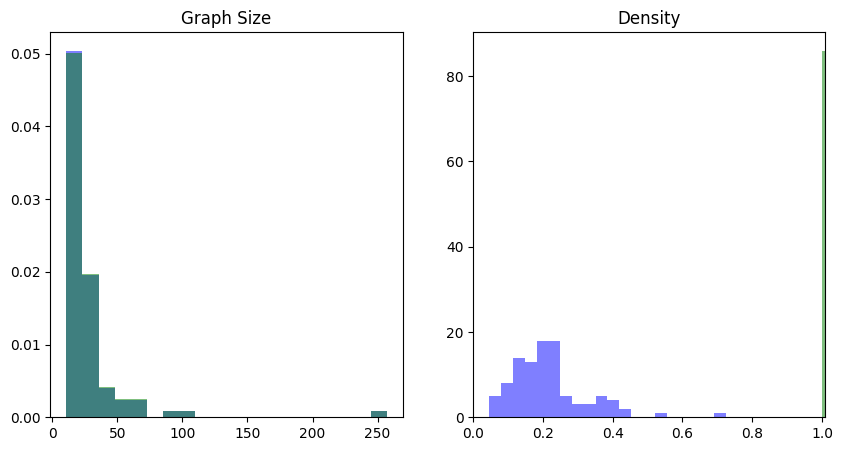

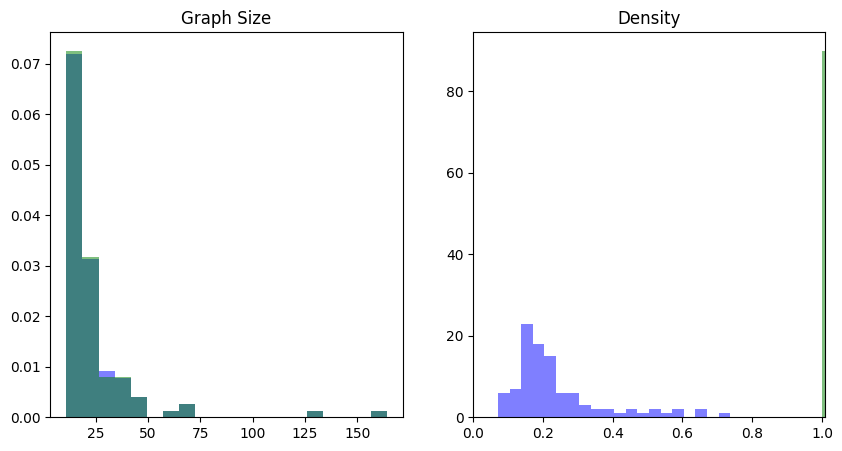

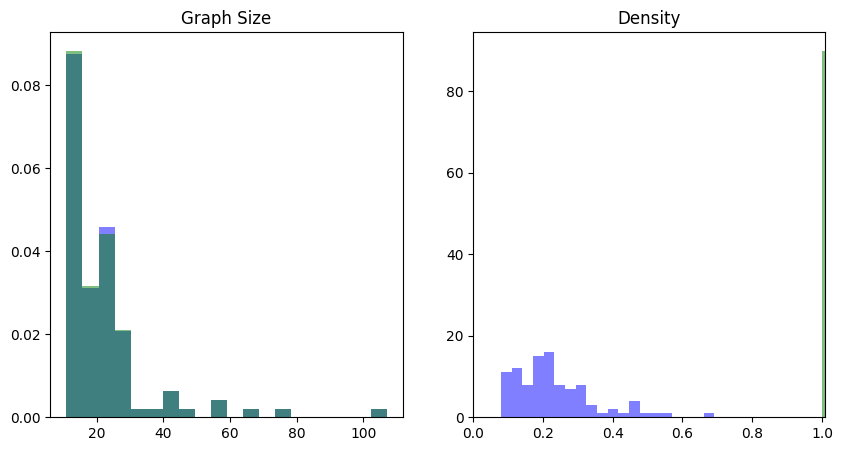

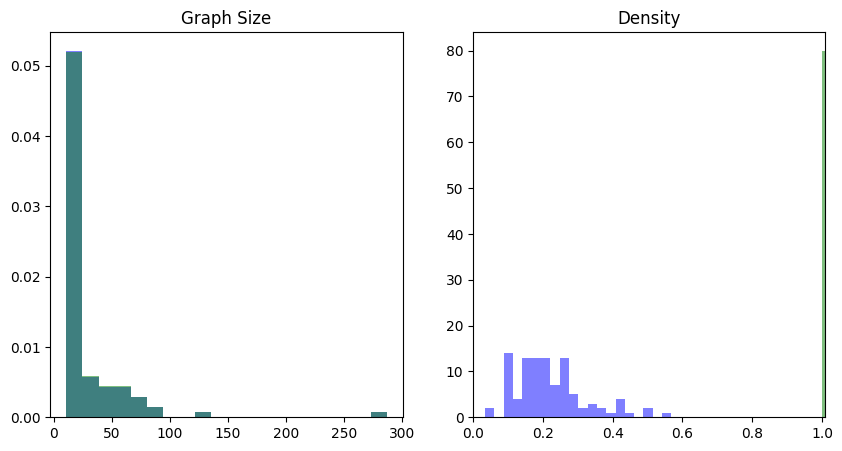

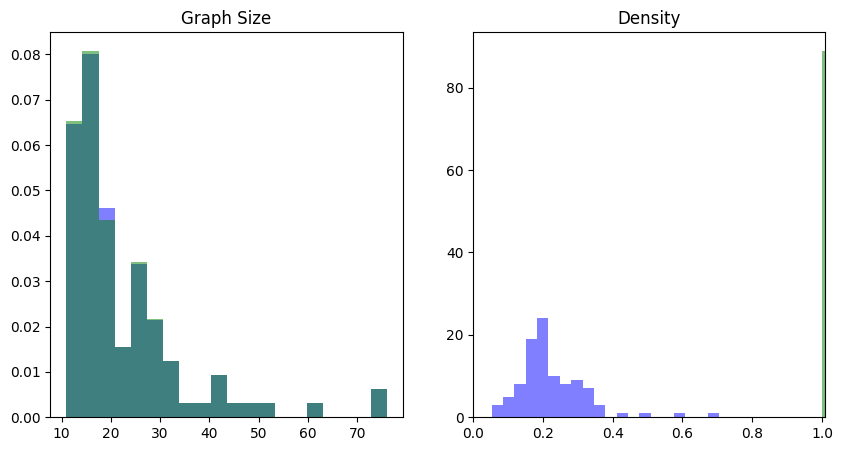

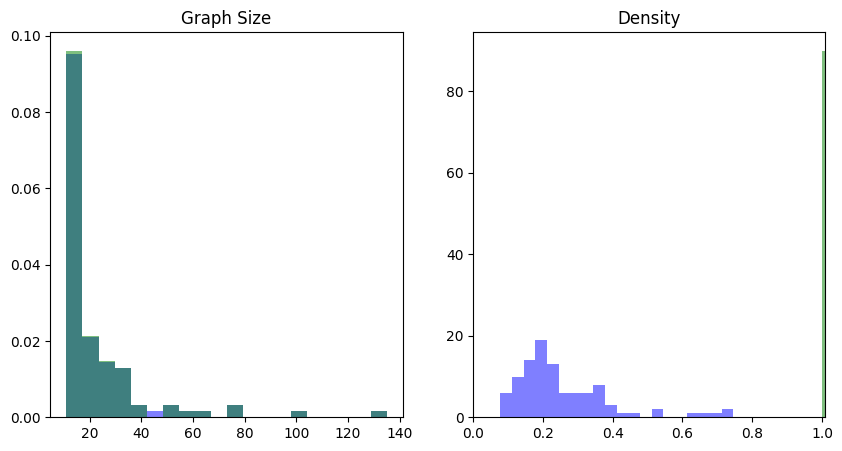

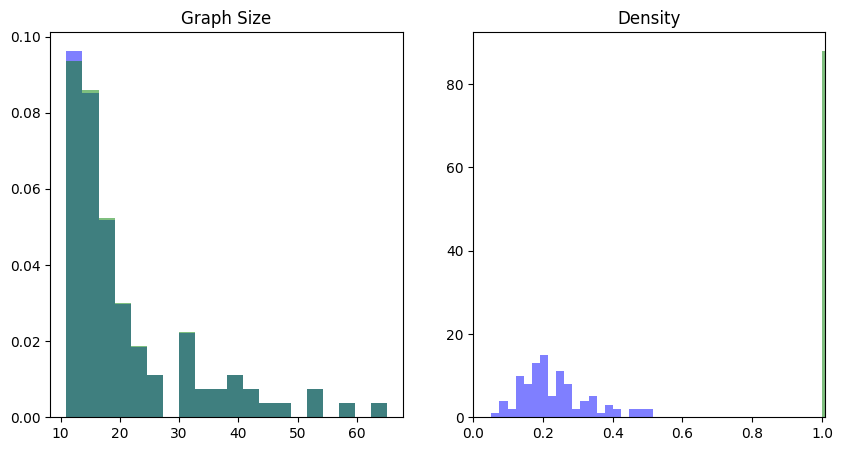

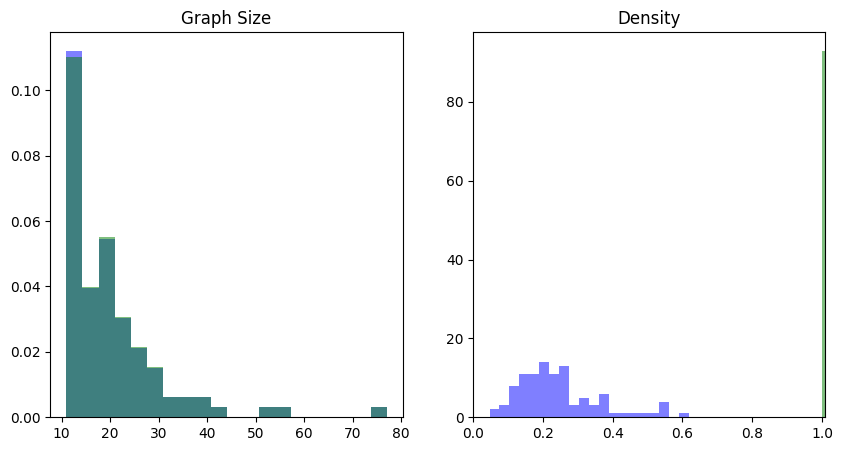

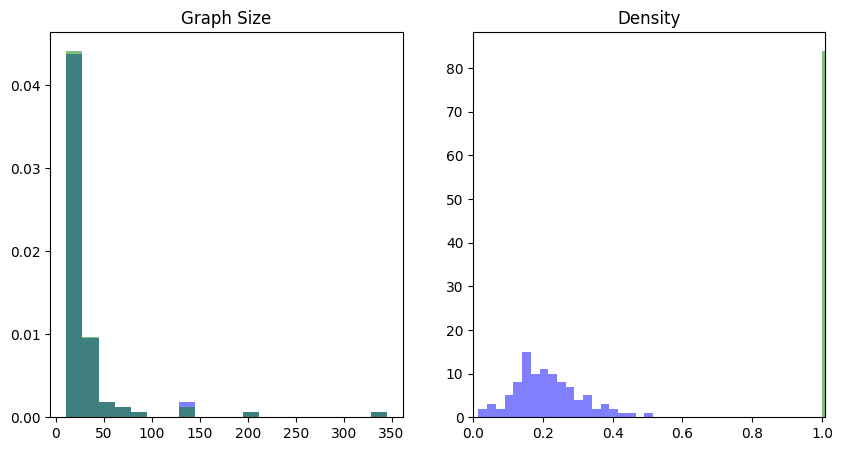

In [73]:
for i in range(1, 11):
    summarize(training_graphs[i], synthetic_graphs[i])

Kernel stuff.

In [10]:
import grakel
from grakel.utils import graph_from_networkx

def _grak(graphs):
    # Add a label to the graphs, for compatibility with grakel.
    for G in graphs:
        # Relabel the graph nodes (useful for the kernel).
        nx.set_node_attributes(G, dict(zip(G.nodes, range(len(G.nodes)))), "label")
    return graph_from_networkx(graphs, node_labels_tag="label")

In [11]:
from grakel import WeisfeilerLehman, VertexHistogram
kernel = WeisfeilerLehman(n_iter=4, base_graph_kernel=VertexHistogram, normalize=True)

Privacy evaluation: we will use the max-similarity (max-kernel) score, which doesn't require any training.

In [12]:
from sklearn.metrics import roc_curve, roc_auc_score

In [13]:
def privacy_evaluation(synthetic_dataset, training_dataset, test_dataset):
    # Fit the kernel on the synthetic graphs.
    kernel.fit(_grak(synthetic_dataset))
    score_train = kernel.transform(_grak(training_dataset)).max(axis=1)
    score_test = kernel.transform(_grak(test_dataset)).max(axis=1)
#     score_train = np.percentile(kernel.transform(_grak(training_dataset)), 0.95, axis=1)
#     score_test = np.percentile(kernel.transform(_grak(test_dataset)), 0.95, axis=1)
    scores = np.concatenate((score_train, score_test))
    labels = np.array([1]*len(training_dataset) + [0]*len(test_dataset))
    plt.figure(figsize=(10, 5))
    print('AUC:', roc_auc_score(labels, scores))
    # ROC curve for these scores.
    plt.subplot(1, 2, 1)
    fpr, tpr, _ = roc_curve(labels, scores)
    plt.plot(fpr, tpr)
    plt.plot([0,1], [0,1], 'k--', alpha=.1)
    plt.xlim([-0.01, 1])
    plt.ylim([0, 1.01])
    # Distributions of scores
    plt.subplot(1, 2, 2)
    bins = np.linspace(np.min(scores), np.max(scores), 21)
    plt.hist(score_train, bins, facecolor='g', alpha=.5, density=True)
    plt.hist(score_test, bins, facecolor='r', alpha=.5, density=True)

Safety check: if the synthetic graphs are the training graphs, this should have perfect accuracy. Note that this also verifies that the testing and training datasets are disjoint (not all of them are, but it doesn't really matter at this point in time).

AUC: 1.0
AUC: 0.995
AUC: 1.0
AUC: 0.995
AUC: 1.0
AUC: 1.0
AUC: 1.0
AUC: 1.0
AUC: 0.9849999999999999
AUC: 1.0


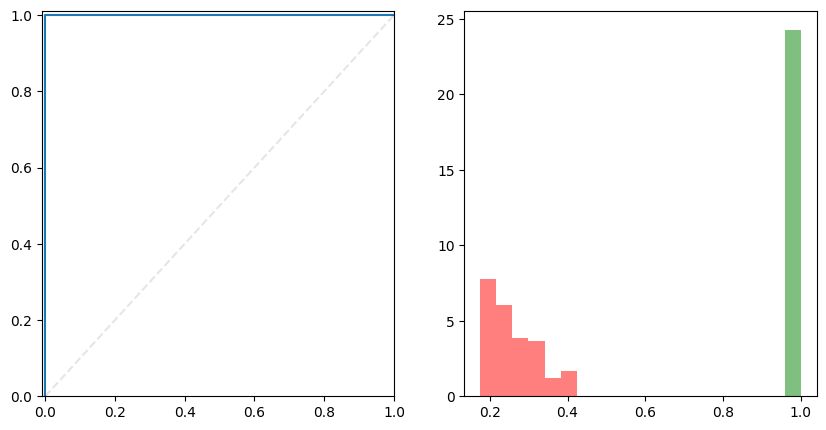

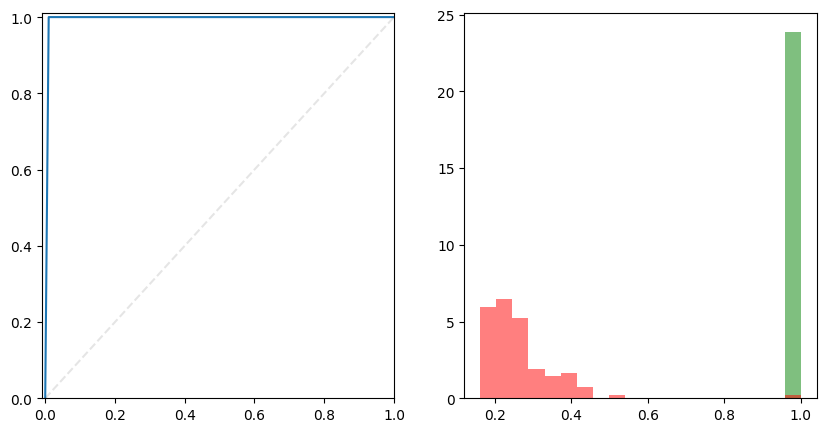

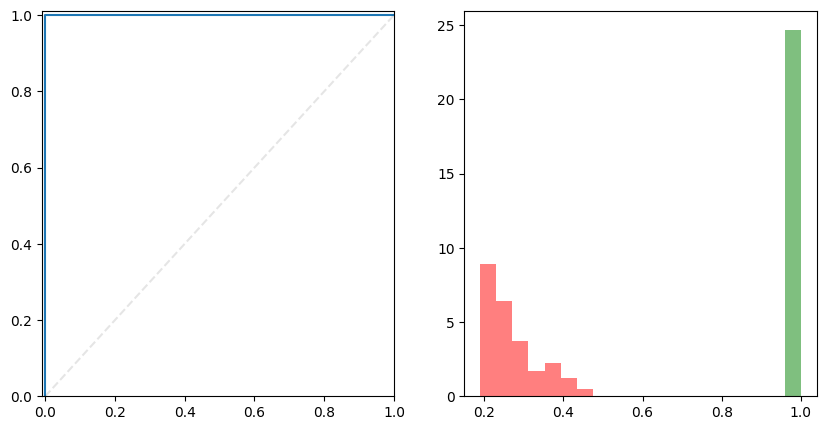

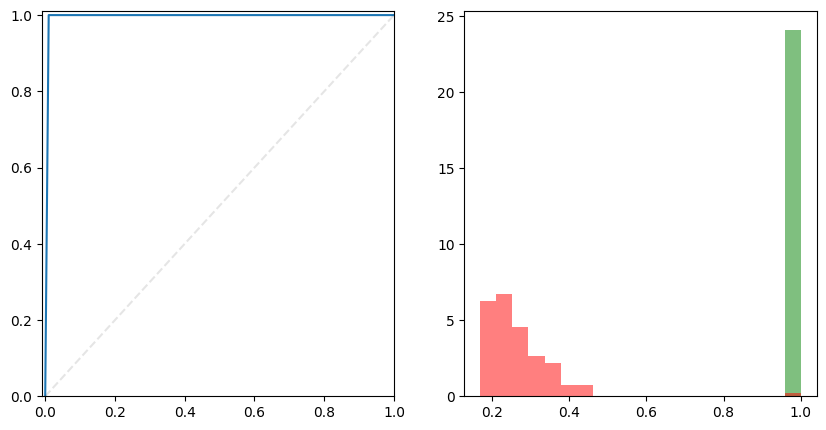

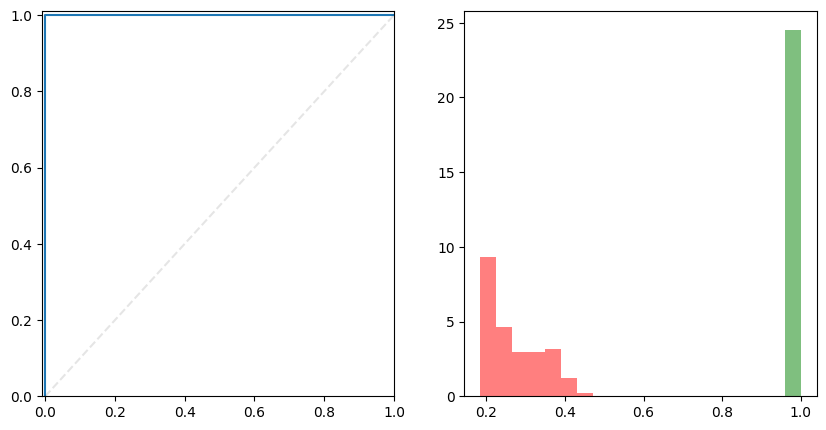

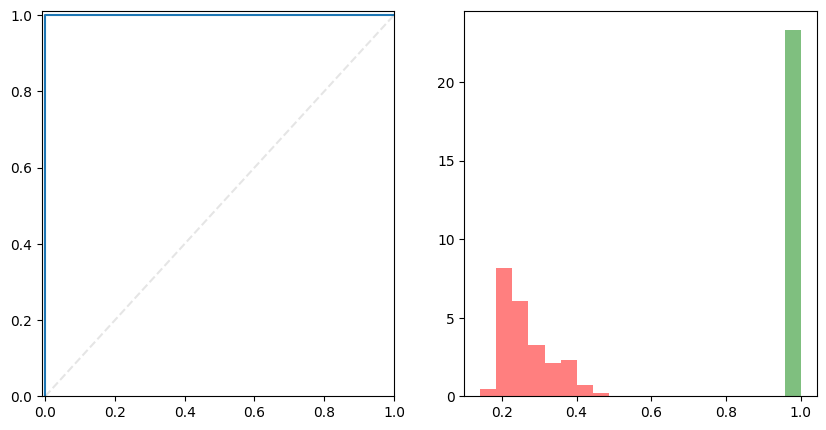

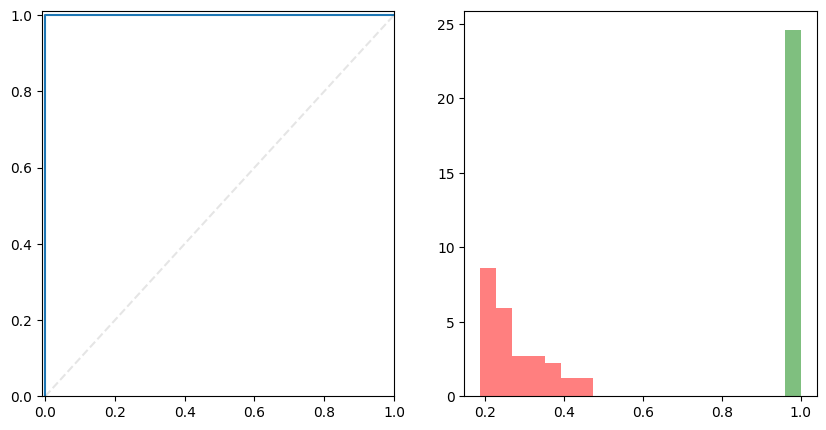

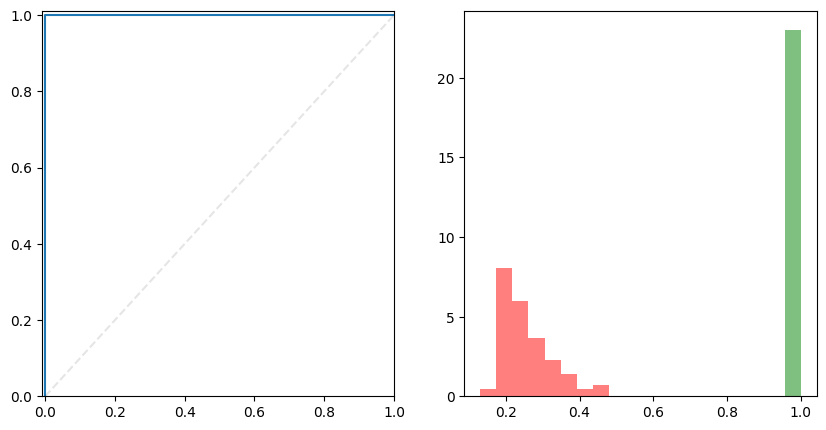

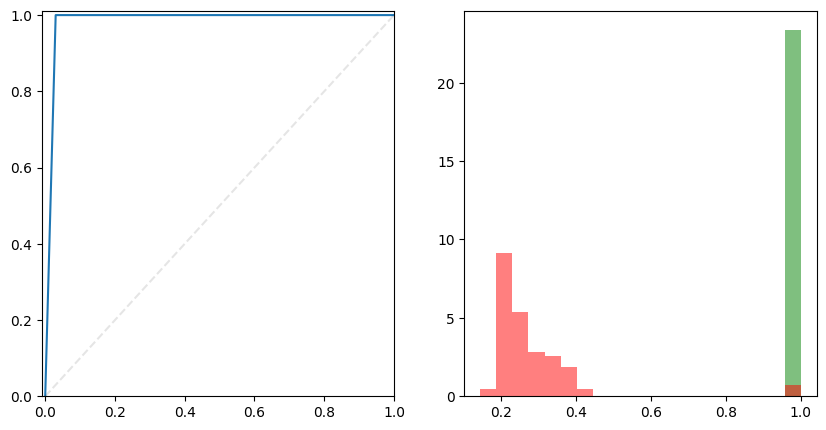

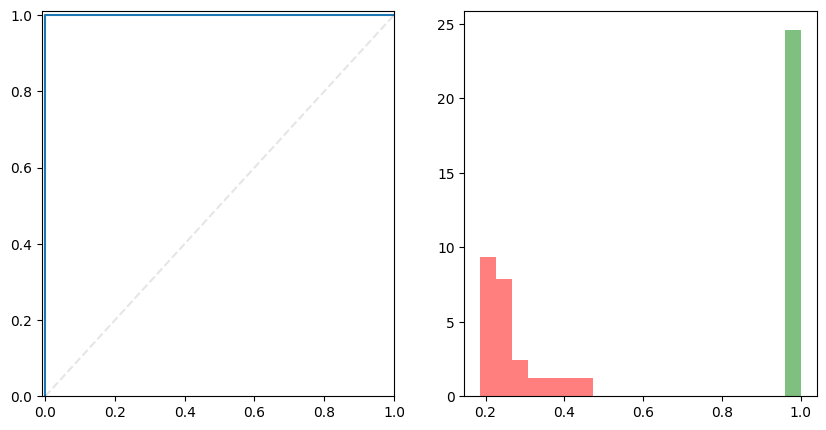

In [14]:
for i in range(1, 11):
    privacy_evaluation(training_graphs[i], training_graphs[i], testing_graphs)  # It does!

Moment of truth.

AUC: 0.5700000000000001
AUC: 0.58
AUC: 0.5895999999999999
AUC: 0.575
AUC: 0.565
AUC: 0.575
AUC: 0.56465
AUC: 0.565
AUC: 0.5850000000000001
AUC: 0.55965


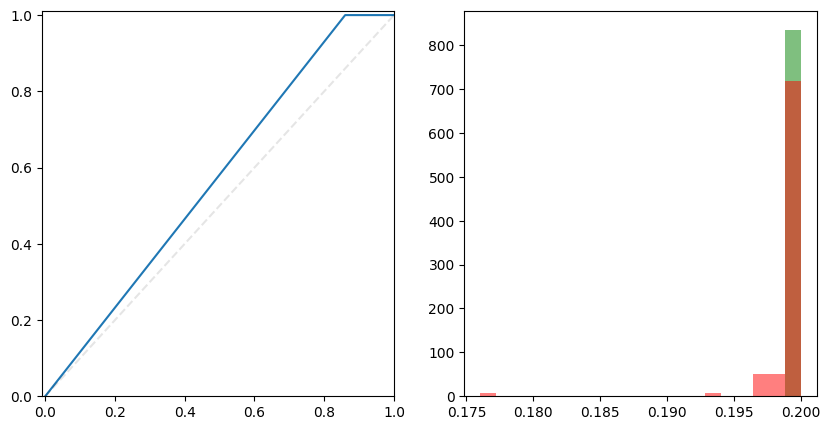

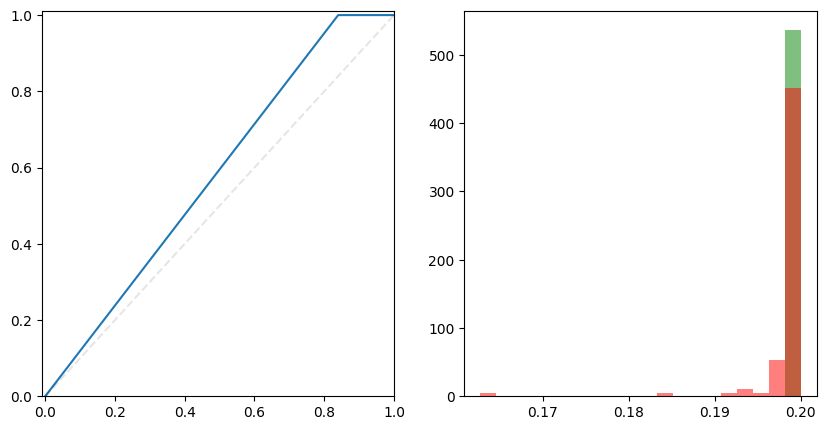

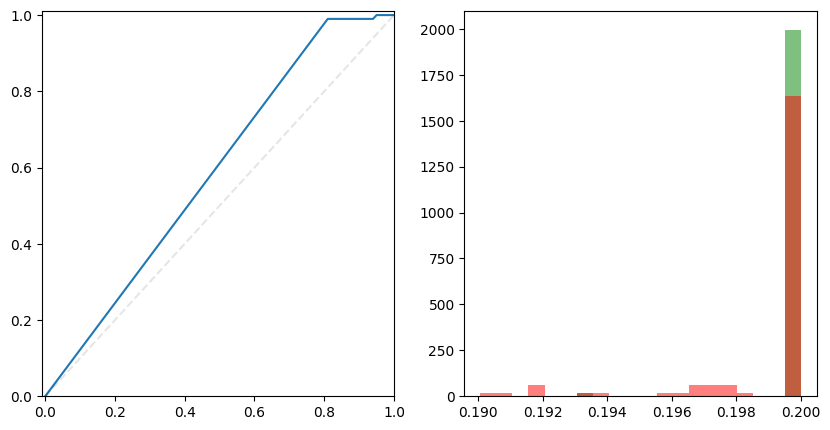

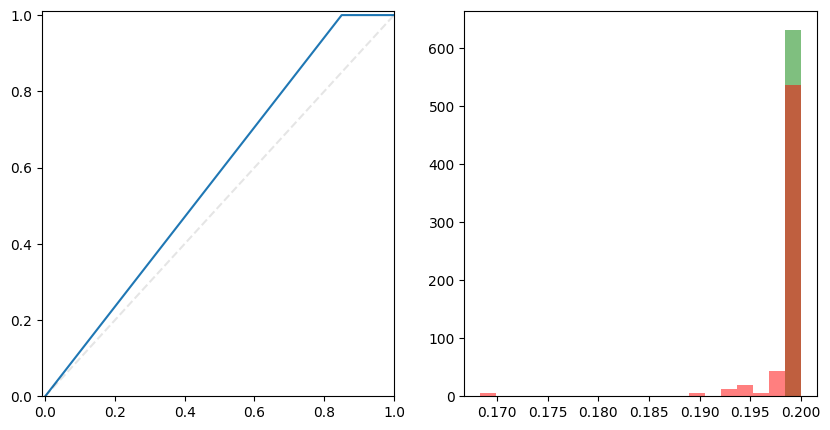

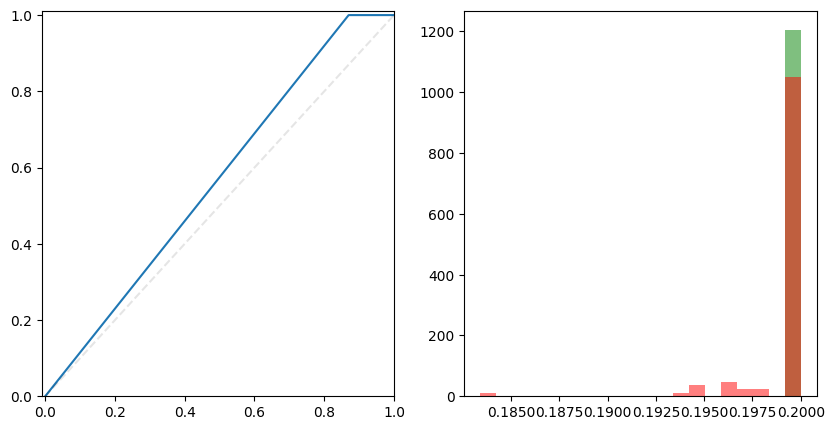

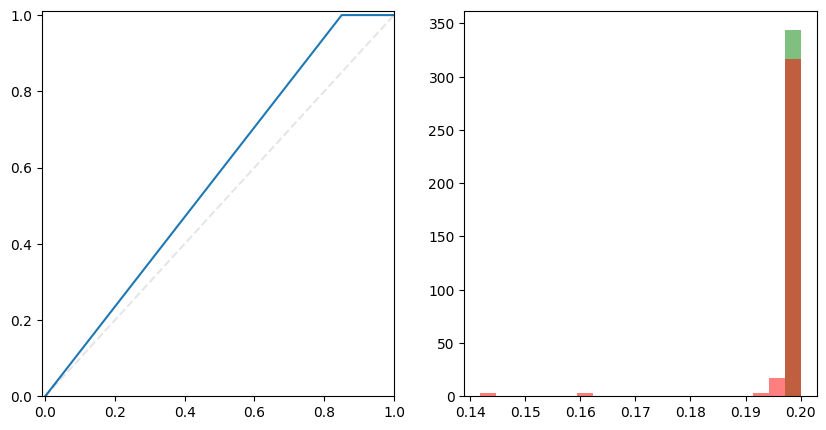

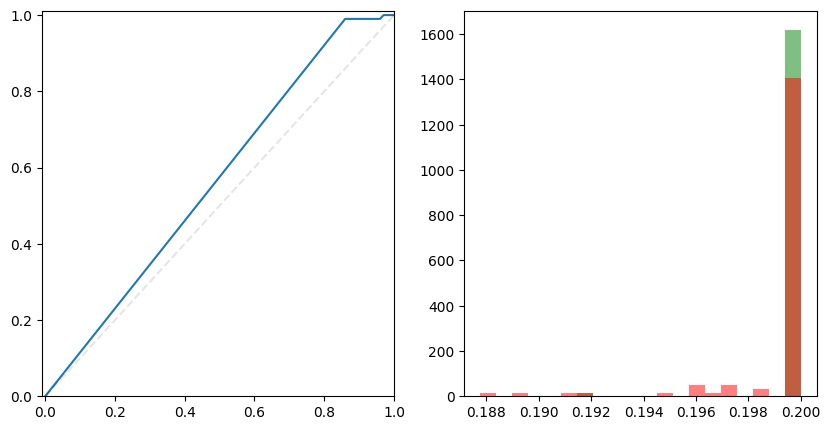

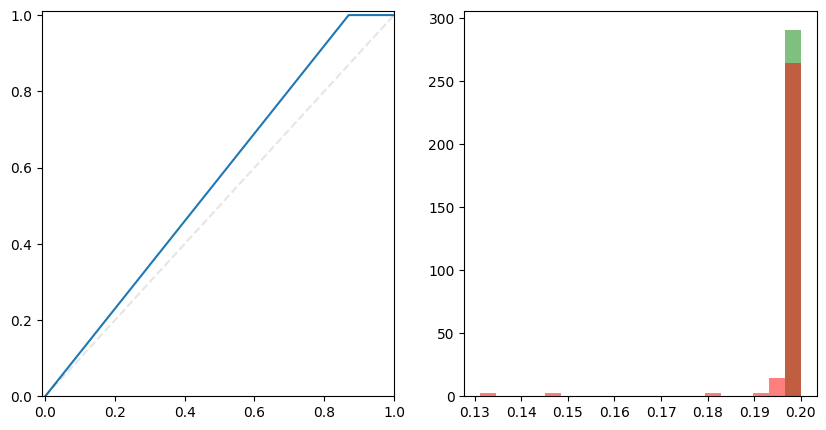

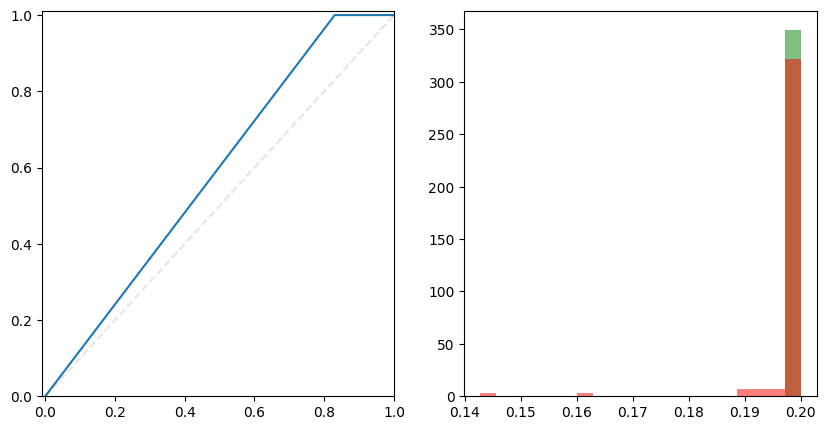

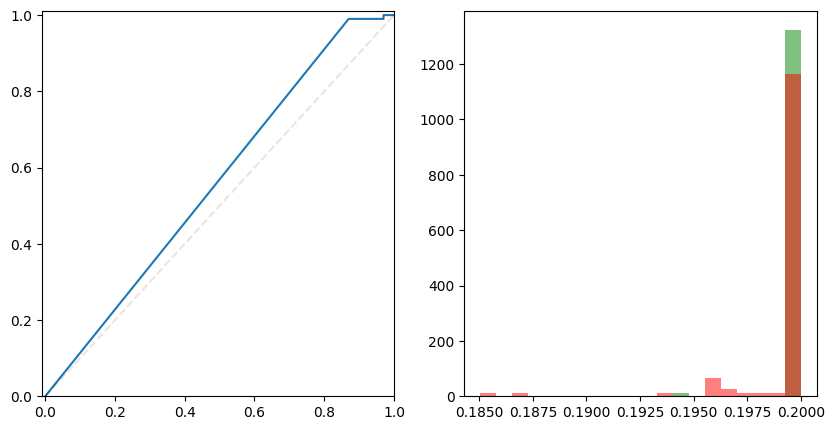

In [15]:
for i in range(1, 11):
    privacy_evaluation(synthetic_graphs[i], training_graphs[i], testing_graphs)

We can actually have a more robust negative sample size by taking all other sets as testing.

AUC: 0.5543750000000001
AUC: 0.56
AUC: 0.5784374999999999
AUC: 0.575625
AUC: 0.578125
AUC: 0.5599999999999999
AUC: 0.5682437499999999
AUC: 0.56625
AUC: 0.5662499999999999
AUC: 0.5795277777777779


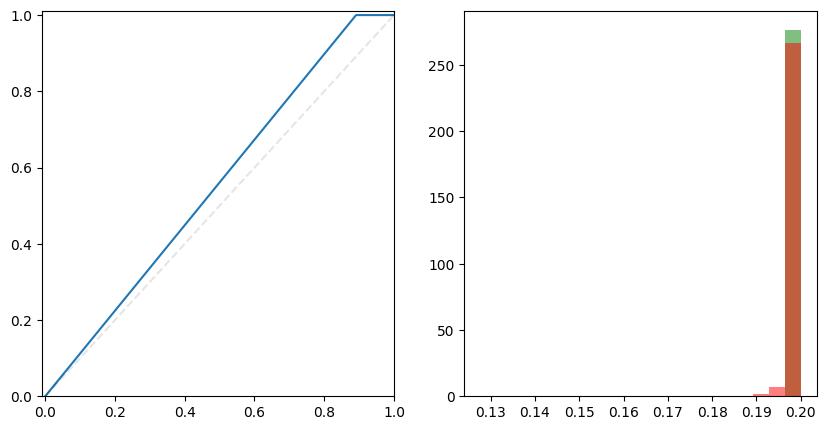

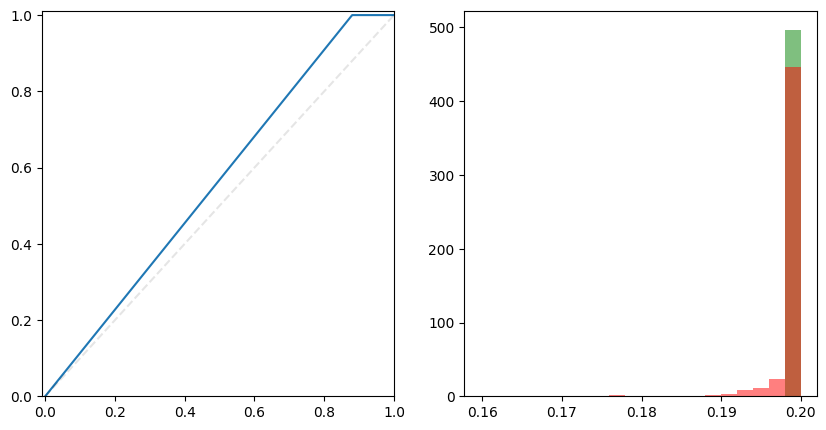

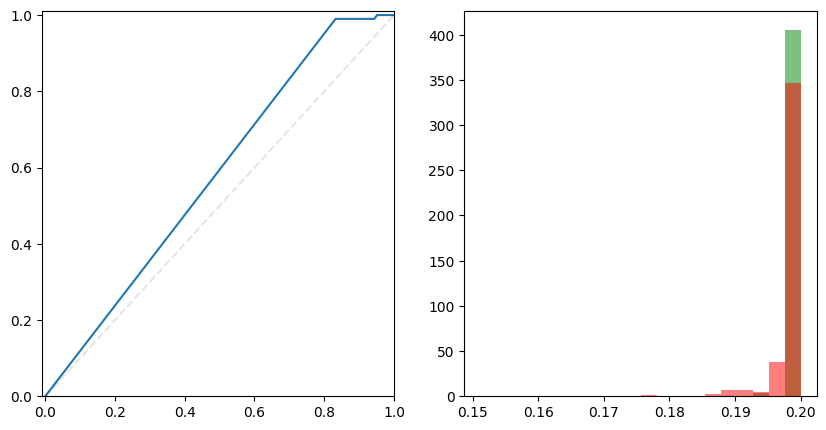

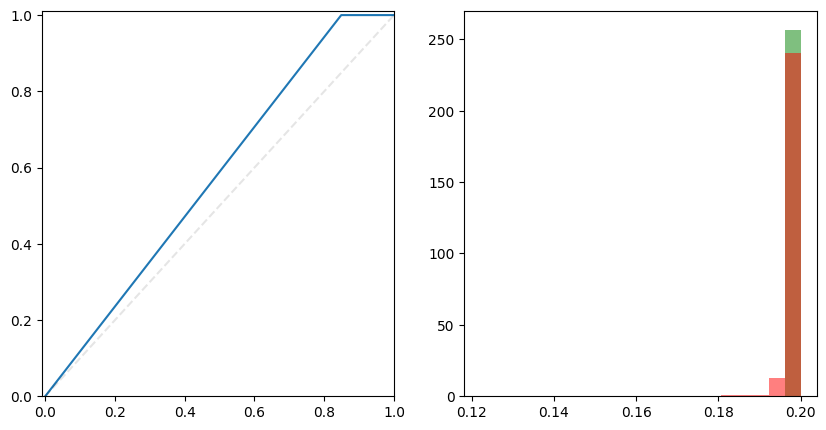

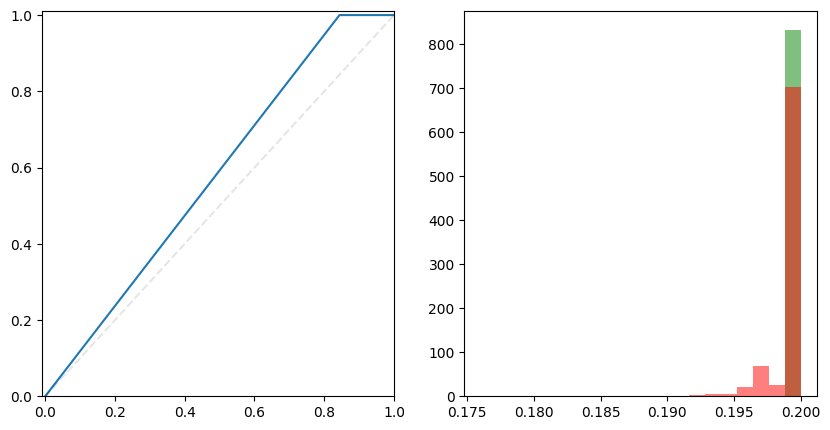

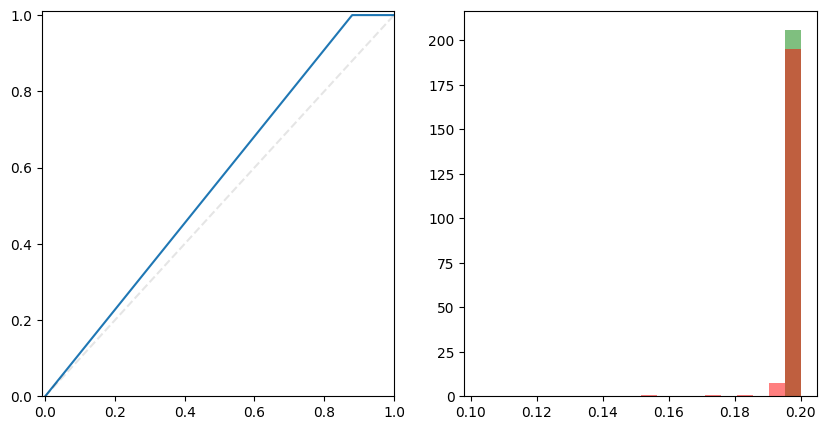

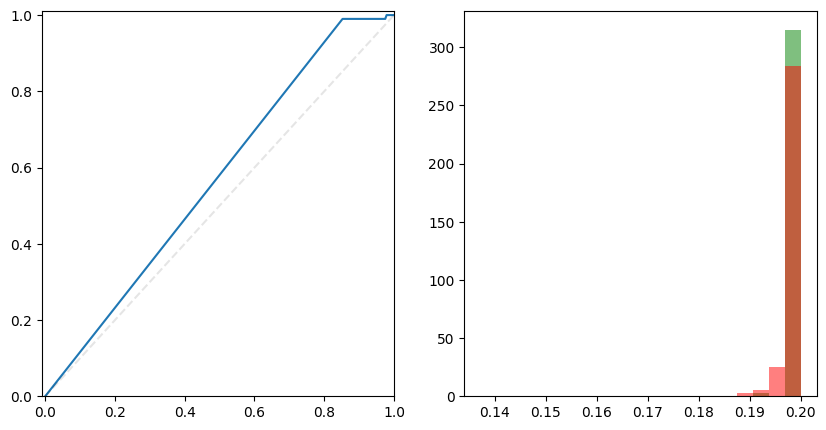

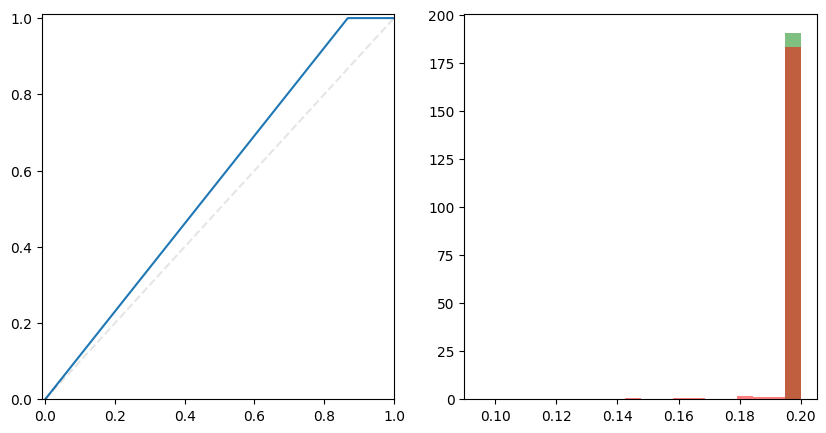

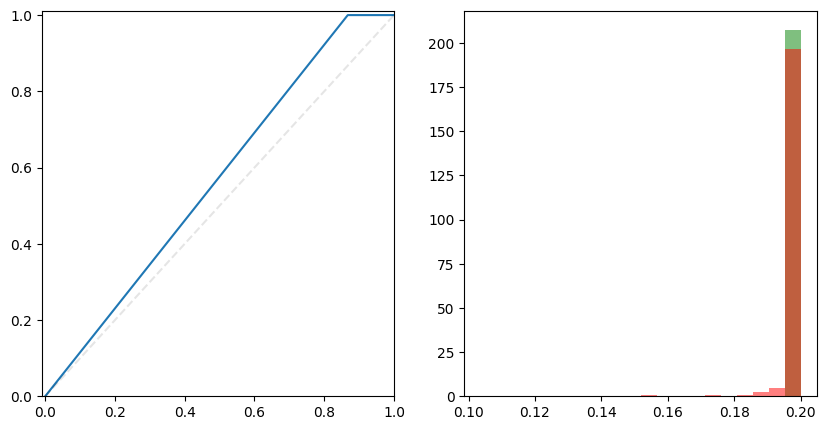

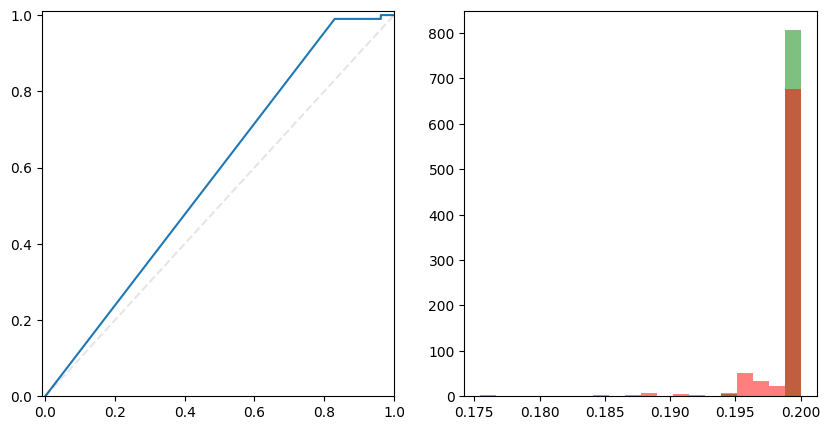

In [16]:
for i in range(1, 11):
    privacy_evaluation(
        synthetic_graphs[i],
        training_graphs[i],
        # Somewhat ugly code: concatenate all lists of testing graphs of different indices.
        sum([training_graphs[ii] for ii in range(1, 10) if ii != i], [])
    )

Additional study: the distribution of kernel values for graphs selected at random in and across sets.

In [17]:
def kernel_distro(dataset1, dataset2):
    s = kernel.fit_transform(_grak(dataset1))
    a1 = [s[i,j] for i, j in zip(*np.triu_indices(s.shape[0])) if i != j]
    s = kernel.fit_transform(_grak(dataset2))
    a2 = [s[i,j] for i, j in zip(*np.triu_indices(s.shape[0])) if i != j]
    kernel.fit(_grak(dataset1))
    s = kernel.transform(_grak(dataset2))
    # allow duplicate indices in the 
    a3 = [s[i,j] for i, j in zip(*np.triu_indices(s.shape[0], m=s.shape[1])) if i != j]
    bins = np.linspace(
        min(np.min(a1), np.min(a2), np.min(a3)),
        max(np.max(a1), np.max(a2), np.max(a3)),
        25
    )
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.hist(a1, bins, facecolor='g', density=True)
    plt.title('Kernel of random synthetic graphs')
    plt.subplot(1, 3, 2)
    plt.title('Kernel of a synthetic and a training graph')
    plt.hist(a3, bins, facecolor=(0, 1, 1), density=True)
    plt.subplot(1, 3, 3)
    plt.title('Kernel of random training graphs')
    plt.hist(a2, bins, facecolor='b', density=True)

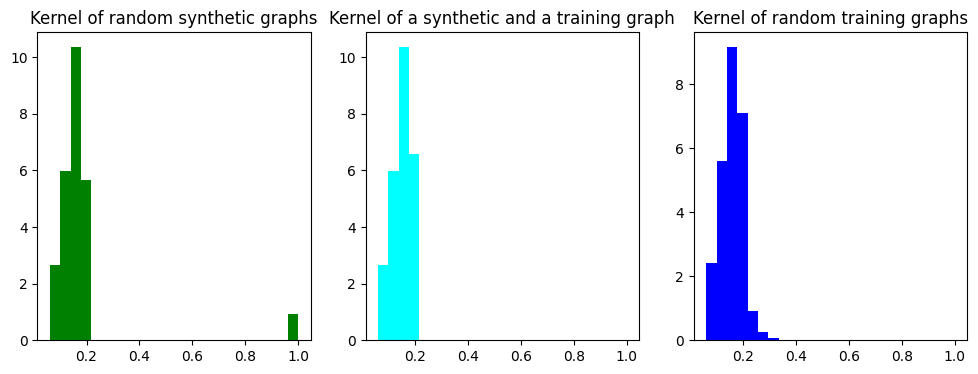

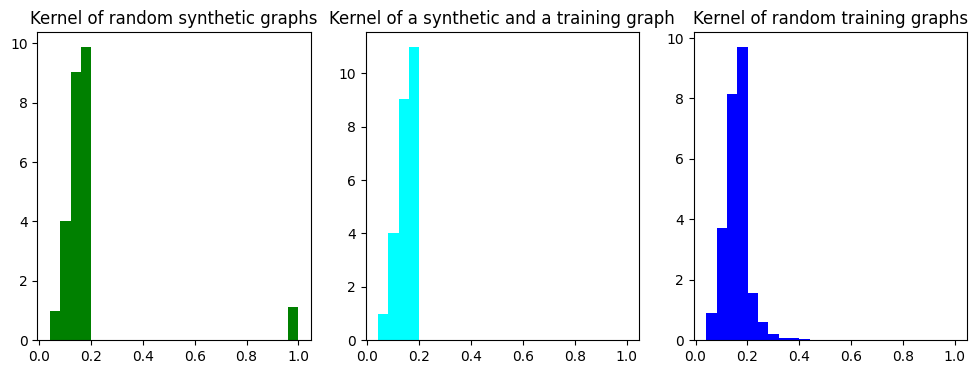

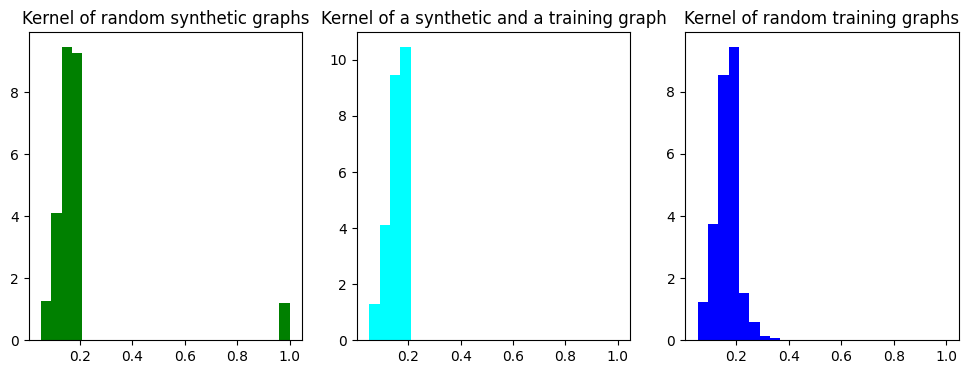

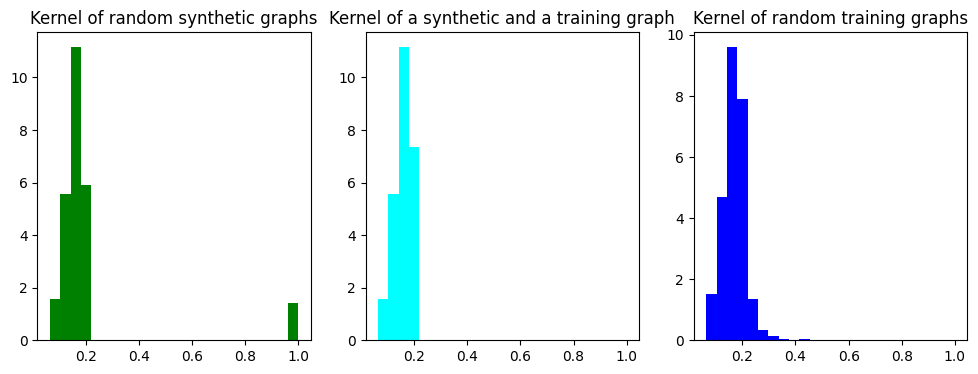

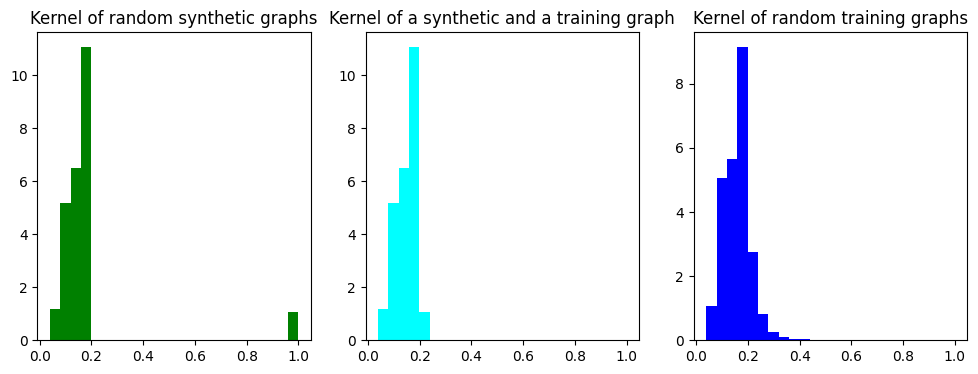

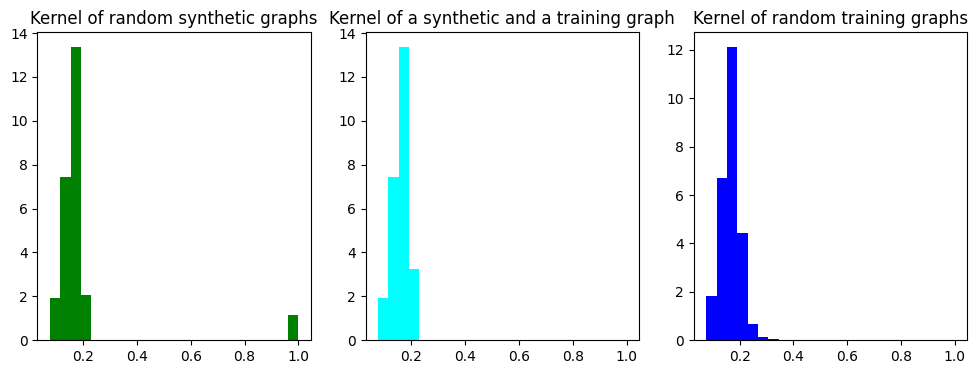

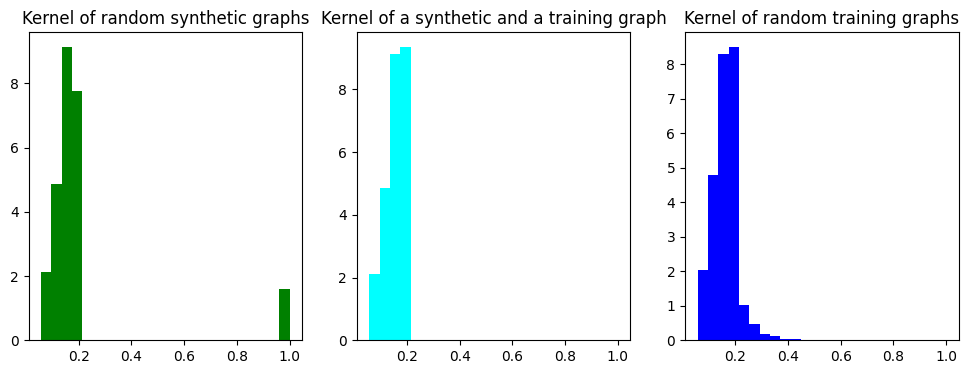

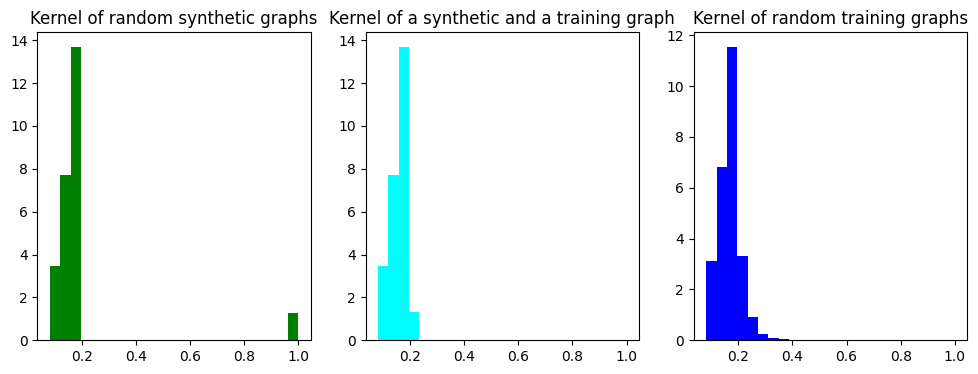

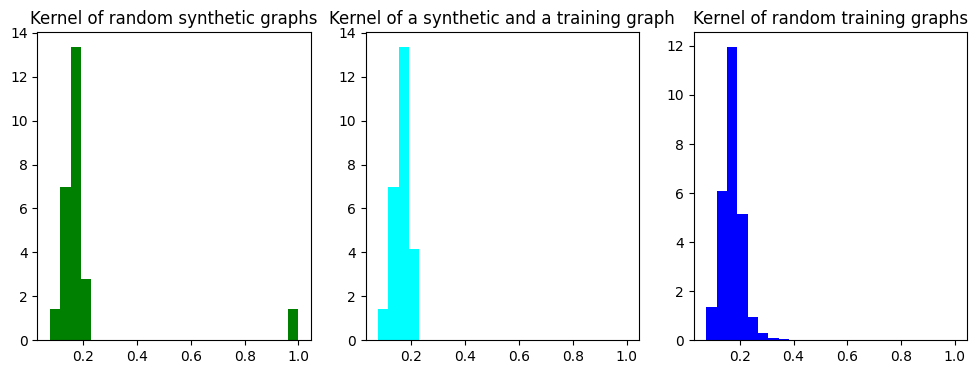

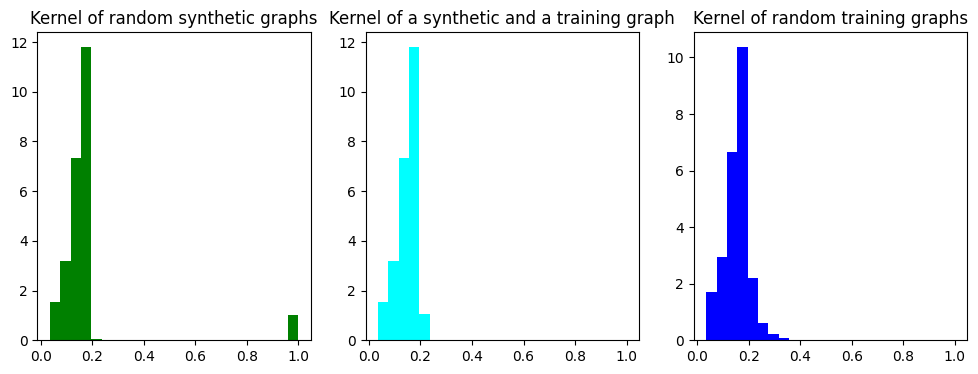

In [18]:
for i in range(1, 11):
    kernel_distro(synthetic_graphs[i], training_graphs[i])